In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions

from linux_qm.src.render import draw_reacting_mapnums

In [2]:
df = pd.read_csv('../data/slv_amides/amide_mapped_training_set.csv')
df.sample(5)

,rxn_id,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi
1817,8709030,OC(c1c2[s]cc(COc3c(C)ccc(-c4c[n](C)[n][n]4)c3)...,NCCO,[CH3:1][c:2]1[c:13]([O:14][CH2:15][c:16]2[c:31...,NaN,60.0,[NH2:1][CH2:2][CH2:3][OH:4].O[C:6](=[O:32])[c:...
8203,28919173,OC(c1cccc(OC)c1)=O,N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1ccccc1)C(O)C(=O...,[CH3:1][O:2][c:3]1[cH:35][c:7]([C:8]([NH:10][C...,Other,100.0,[NH2:1][C@H:2]([C:7]([NH:9][C@H:10]([CH:18]([C...
2776,10737906,OC(c1cc(OCc2c(C)o[n]c2-c2ccc(F)c[n]2)[n][s]1)=O,NC1CCOC1,[CH3:1][c:2]1[c:13]([CH2:14][O:15][c:16]2[n:28...,TBD,27.0,[NH2:1][CH:2]1[CH2:6][O:5][CH2:4][CH2:3]1.O[C:...
513,5210608,OC(=O)c1c(C)[n]c2[n](-c3c(C)cc(C)cc3C)c3ccccc3...,CCCNCC1CC1,[CH3:1][CH2:2][CH2:3][N:4]([C:9]([c:11]1[n:32]...,Trimethylaluminum,90.0,[CH3:1][CH2:2][CH2:3][NH:4][CH2:5][CH:6]1[CH2:...
3640,13435762,OC(c1cccc(-c2cc3[n]c(NC)c4[n](c3[s]2)c(C)c[n]4...,NCCO,[CH3:1][NH:2][c:3]1[c:27]2[n:22]([c:23]([cH:25...,NaN,76.0,[NH2:1][CH2:2][CH2:3][OH:4].O[C:6](=[O:28])[c:...


In [4]:
df.activators_names.value_counts()

activators_names
N-Hydroxysuccinimide       1373
Anhydrides                  749
Other                       507
Pentafluorophenol           327
4-Nitrophenol               287
HATU                        260
Trimethylaluminum           237
HOBt + EDAP                 228
TBD                         178
Potassium tert-butoxide     168
HOBt                        122
Sodium methoxide            118
HOAt + EDAP                 106
HBTU                         57
EDAP                         56
BOP                          40
Name: count, dtype: int64

[NH:1]1[CH2:6][CH2:5][NH:4][CH2:3][CH2:2]1.O[C:8]([c:10]1[c:16]([OH:17])[cH:15][cH:14][c:12]([Cl:13])[cH:11]1)=[O:9]>>[O:9]=[C:8]([c:10]1[cH:11][c:12]([Cl:13])[cH:14][cH:15][c:16]1[OH:17])[N:1]1[CH2:6][CH2:5][NH:4][CH2:3][CH2:2]1
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 20


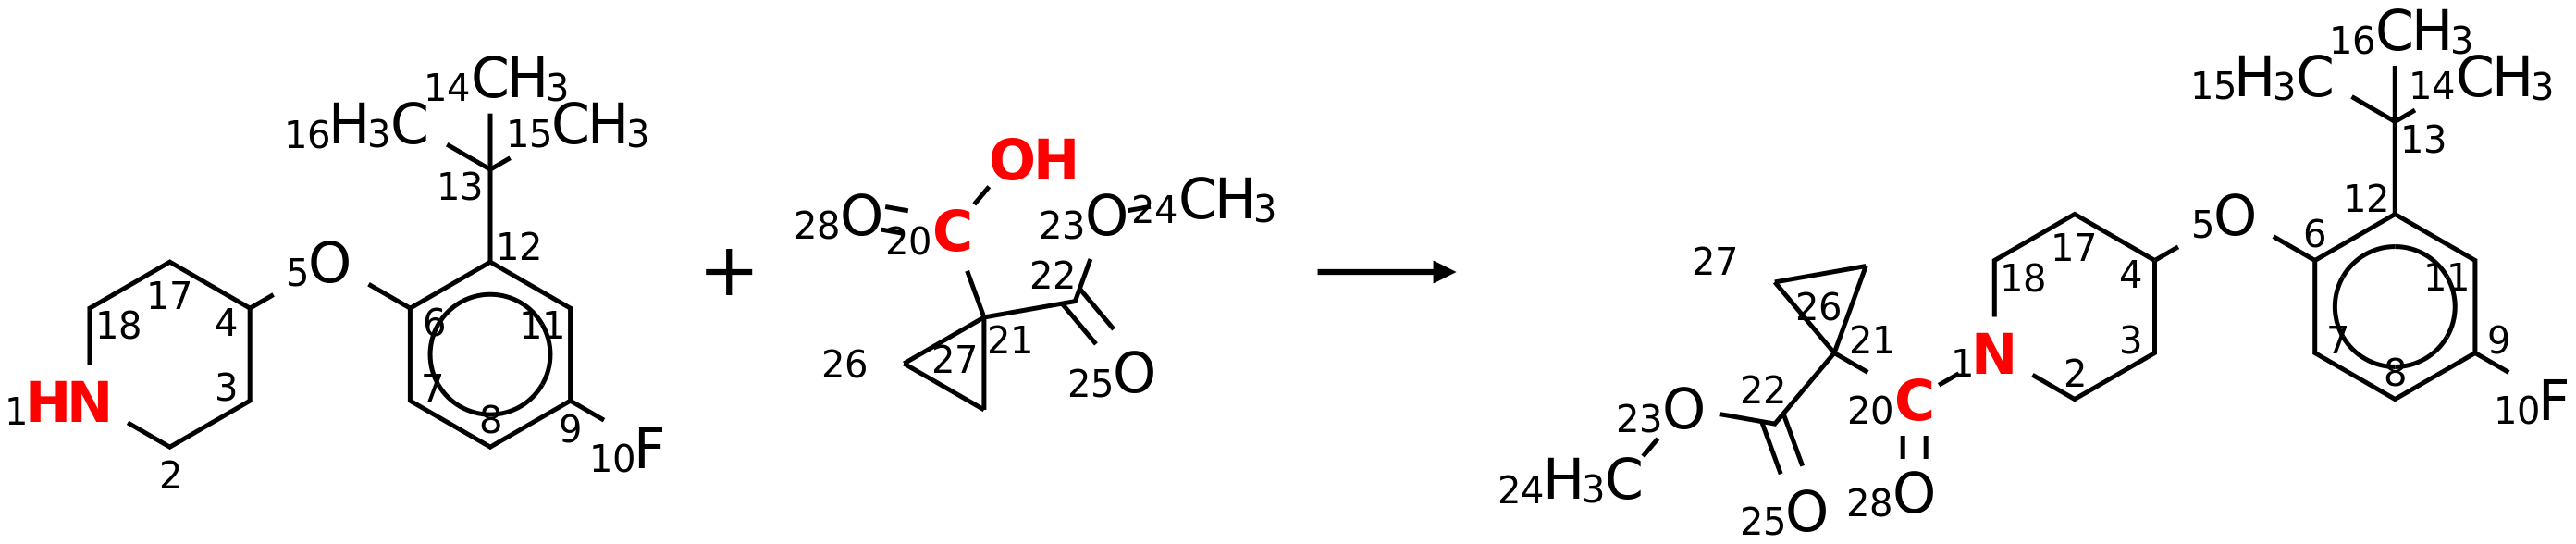

[1, 0, 20]

In [11]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(rxn_smi)
draw_reacting_mapnums(df.rxn_smi.sample(1).iat[0])

# SMARTS Amine Descriptor

In [12]:
amine_smarts_df = pd.read_csv('../data/smarts/Amine_SMARTS.csv')
amine_smarts_df

,SMARTS,Description
0,[NH2],primary amine
1,[NH1],secondary amine
2,[NH1;r3],amine in a 3-membered ring
3,[NH1;r4],amine in a 4-membered ring
4,[NH1;r5],amine in a 5-membered ring
...,...,...
128,"[NX3;H2,H1]-a1aanaa1",N - para aromatic N in aromatic 6-membered aro...
129,"[NX3;H2,H1]-a1a(-[CH3])aaaa1",CH3 in -orto position across 6-membered aromat...
130,"[NX3;H2,H1]-a1a(-[CH2][CH2])aaaa1",CH2-CH2 in -orto position across 6-membered ar...
131,"[NX3;H2,H1]-a1a(-[CH]([C])[C])aaaa1",iPr-scaffold in -orto position across 6-member...


In [13]:
smarts = amine_smarts_df.SMARTS.iat[8]
query = Chem.MolFromSmarts(smarts)
query

def check_query(smarts):
    try:
        Chem.MolFromSmarts(smarts)
        return True
    except:
        return False

amine_smarts_df.SMARTS.apply(check_query).sum() == len(amine_smarts_df)

True

In [14]:
def has_match(smi: str, query):
    mol = Chem.MolFromSmiles(smi)
    return mol.HasSubstructMatch(query)

def match_atoms(smi: str, query):
    mol = Chem.MolFromSmiles(smi)
    return mol.GetSubstructMatch(query)

mol = Chem.MolFromSmiles('Nc1ccccc1')
queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
for query in queries:
    mol.GetSubstructMatch(query)

In [15]:
mask = df.amine_smi.apply(has_match, args=(query,))

(0, 17, 16, 2, 1, 3, 12, 21, 20, 19, 18)
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 24


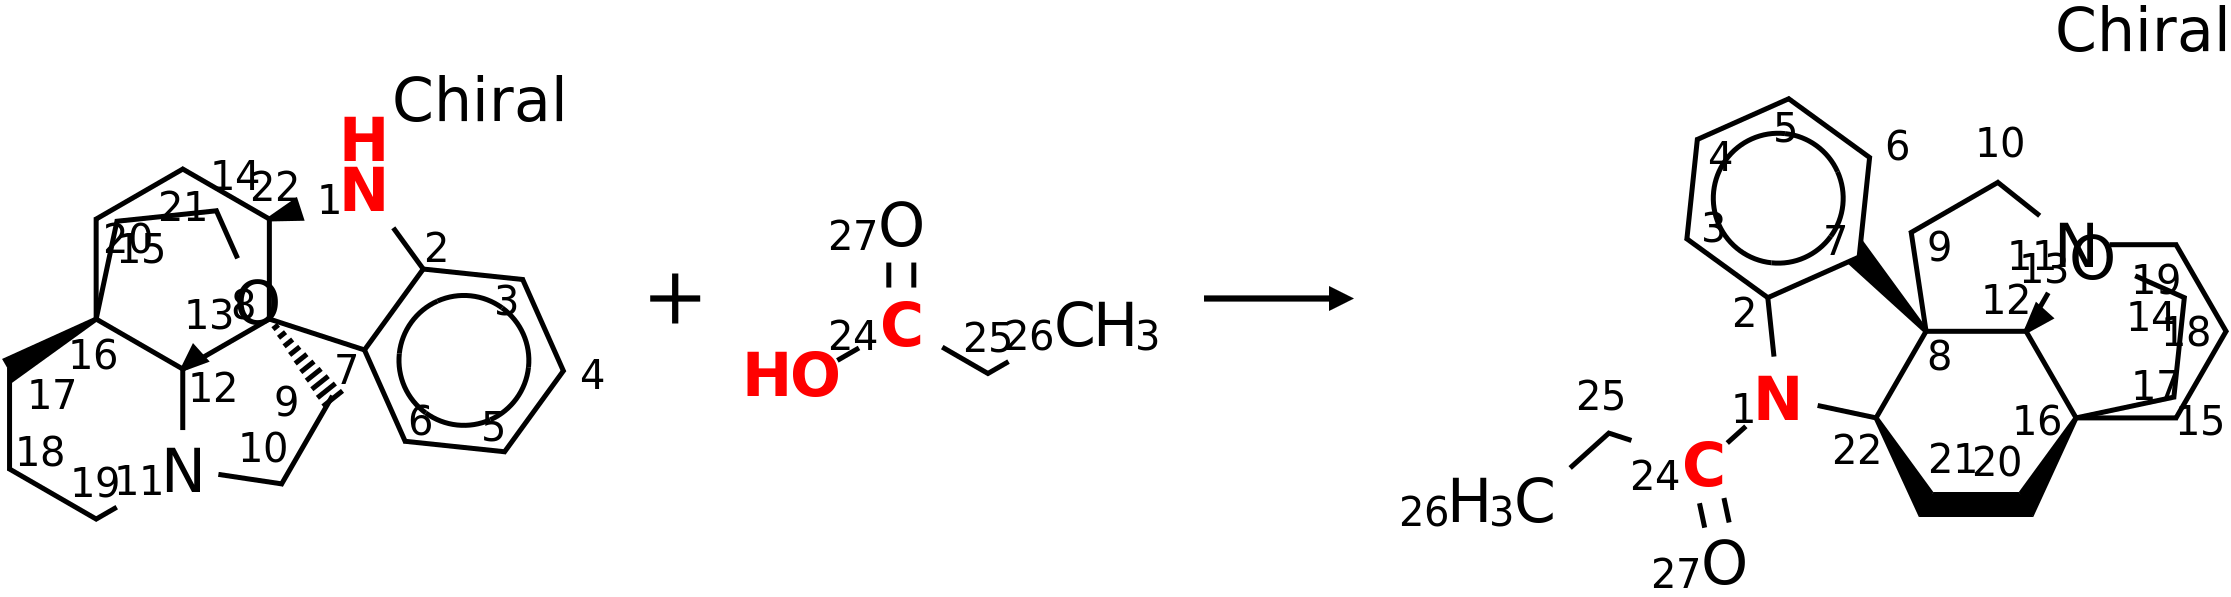

[1, 0, 24]

In [16]:
rxn_smi = df.loc[mask, 'rxn_smi'].sample(1).iat[0]
print(match_atoms(rxn_smi.split('.')[0], query))
draw_reacting_mapnums(rxn_smi)

In [17]:
def match_queries(mol, queries: list, react_atom_id: int):
    size = len(queries)
    result = np.zeros(size, dtype=int)
    for i, query in enumerate(queries):
        result[i] = match_reacting_atom(mol, query, react_atom_id)
    return result

def match_reacting_atom(mol, query, react_atom_id: int):
    try:
        for match_atoms in mol.GetSubstructMatches(query):
            # print('match_atoms:', match_atoms)
            if react_atom_id == match_atoms[0]:
                return True
        return False
    except Exception as e:
        print(f"{type(e).__name__}: {e} \n for query: {Chem.MolToSmarts(query)}\n for smiles: {Chem.MolToSmiles(mol)}")


In [18]:
def load_query(smarts: str):
    query = Chem.MolFromSmarts(smarts)
    query.UpdatePropertyCache()
    Chem.GetSymmSSSR(query)
    return query

queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
# queries = amine_smarts_df.SMARTS.apply(load_query)

def update_props(mol):
    mol.UpdatePropertyCache()
    Chem.GetSymmSSSR(mol)

def smarts_descriptor(rxn_smi, queries: list):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    update_props(amine)
    update_props(acid)
    react_atoms_ids = rxn.GetReactingAtoms()

    react_nitrogen = react_atoms_ids[0][0]
    return match_queries(amine, queries, react_nitrogen)

smarts_descriptor(rxn_smi, queries)

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1])

In [20]:
from linux_qm.desc.smarts import smarts_descriptor

smarts_df = pd.read_csv('../data/smarts/Amine_SMARTS.csv')
amine_queries = smarts_df.SMARTS.apply(Chem.MolFromSmarts)

smarts_df = pd.read_csv('../data/smarts/Acid_SMARTS.csv')
acid_queries = smarts_df.SMARTS.apply(Chem.MolFromSmarts)

smarts_descriptor(rxn_smi, amine_queries,acid_queries )

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# SMARTS Acid descriptor

In [22]:
acid_smarts_df = pd.read_csv('../data/smarts/Acid_SMARTS.csv')
acid_smarts_df

,SMARTS,Description
0,[C](=[O])(-[OH])-[*]~[*+],CA - * - positive charge
1,[C](=[O])(-[OH])-[*]~[*]~[*+],CA - * - * - positive charge
2,[C](=[O])(-[OH])-[*]~[*-],CA - * - negative charge
3,[C](=[O])(-[OH])-[*]~[*]~[*-],CA - * - * - negative charge
4,[C](=[O])(-[OH])-[R]1~[R]~[R]1,CA - ring of size 3
...,...,...
118,[OH]-[C](=[O])-a1aanaa1,N - para aromatic N in aromatic 6-membered aro...
119,[OH]-[C](=[O])-a1a(-[CH3])aaaa1,CH3 in -orto position across 6-membered aromat...
120,[OH]-[C](=[O])-a1a(-[CH2][CH2])aaaa1,CH2-CH2 in -orto position across 6-membered ar...
121,[OH]-[C](=[O])-a1a(-[CH]([C])[C])aaaa1,iPr-scaffold in -orto position across 6-member...


In [23]:
queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)

51


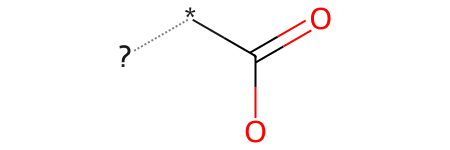

In [24]:
query = queries[0]

mask = df.acid_smi.apply(has_match, args=(query,))
print(mask.sum())

query

In [25]:
count = {}

for query in tqdm(queries[:10]):
    mask = df.acid_smi.apply(has_match, args=(query,))
    count[Chem.MolToSmarts(query)] = mask.sum()

count

100%|██████████| 123/123 [01:55<00:00,  1.06it/s]


{'C(=O)(-[O&H1])-*~[+]': 51,
 'C(=O)(-[O&H1])-*~*~[+]': 45,
 'C(=O)(-[O&H1])-*~[-]': 0,
 'C(=O)(-[O&H1])-*~*~[-]': 51,
 'C(=O)(-[O&H1])-[R]1~[R]~[R]1': 105,
 'C(=O)(-[O&H1])-[R]1~[R]~[R]~[R]1': 27,
 'C(=O)(-[O&H1])-[R]1~[R]~[R]~[R]~[R]1': 1611,
 'C(=O)(-[O&H1])-[R]1~[R]~[R]~[R]~[R]~[R]1': 3316,
 '[O&H1]-C(=O)-[R]1~[R]~[R]~[R]~[R]~[R]~[R]1': 24,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]1': 5,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]~[R]1': 15,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]~[R]~[R]1': 308,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]~[R]~[R]~[R]1': 550,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]~[R]~[R]~[R]~[R]1': 13,
 '[O&H1]-C(=O)-[a&R]': 3901,
 '[O&H1]-C(=O)-[!R]~[a&R]': 497,
 '[O&H1]-C(=O)-[!R]~[!R]~[a&R]': 754,
 '[O&H1]-C(=O)-[A&R]': 1112,
 '[O&H1]-C(=O)-[!R]~[A&R]': 265,
 '[O&H1]-C(=O)-[!R]~[!R]~[A&R]': 103,
 '[O&H1]-C(=O)~[#7,#8,#15,#16]': 0,
 '[O&H1]-C(=O)~*~[#7,#8,#15,#16]': 3601,
 '[O&H1]-C(=O)~*~*~[#7,#8,#15,#16]': 4223,
 '[O&H1]-C(=O)-[C&H3]': 0,
 '[O&H1]-C(=O)-[C&H2]-[C&H3]': 179,
 '[O&H1]-C(=O)-[C&H2]': 3100,
 '[O&H1]-C(=O)

In [27]:
def get_first_ratom_acid(rxn_smi):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    react_atoms_ids = rxn.GetReactingAtoms()
    react_carbon = react_atoms_ids[1][1]
    return acid.GetAtomWithIdx(react_carbon).GetSymbol()

o_mask = df.rxn_smi.apply(get_first_ratom_acid) == 'O'

Reacting Atom Idx: ((1,), (7, 9))
Mapped reacting atom: N 2
Mapped reacting atom: C 6
Mapped reacting atom: O 0


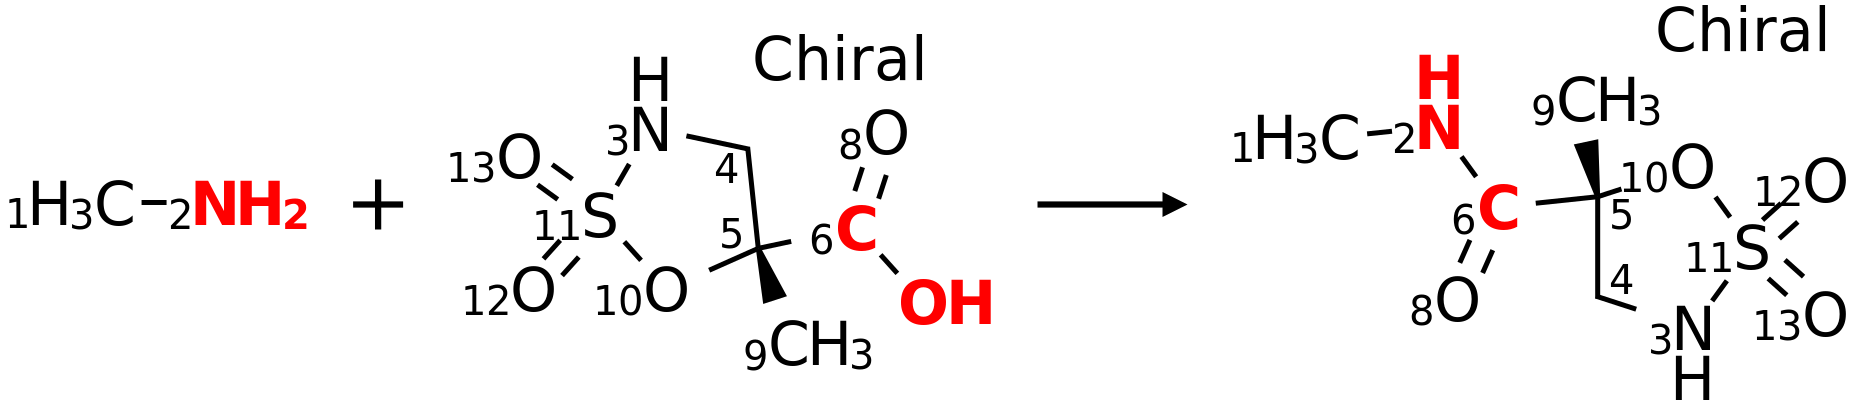

[2, 6, 0]

In [28]:
draw_reacting_mapnums(df[o_mask].sample(1).rxn_smi.iat[0])

In [29]:
def find_acid_carbon(acid, react_atoms: list):
    for i in react_atoms:
        if acid.GetAtomWithIdx(i).GetSymbol() == 'C':
            return i

In [30]:
def smarts_descriptor(rxn_smi, amine_queries: list, acid_queries: list):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    update_props(amine)
    update_props(acid)
    react_atoms_ids = rxn.GetReactingAtoms()

    react_nitrogen = react_atoms_ids[0][0]
    react_carbon = find_acid_carbon(acid, react_atoms_ids[1])
    amine_descr = match_queries(amine, amine_queries, react_nitrogen)
    acid_descr = match_queries(acid, acid_queries, react_carbon)
    return np.hstack([amine_descr, acid_descr])

amine_queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
acid_queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
smarts_descriptor(rxn_smi, amine_queries ,acid_queries)

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
from rdkit import Chem
import pandas as pd

from linux_qm.desc.smarts import smarts_descriptor

rxn_smi = "[NH2:1][CH2:2][CH2:3][c:4]1[cH:9][cH:8][cH:7][cH:6][cH:5]1.O[C:11](=[O:15])[CH2:12][C:13]#[N:14]>>[N:14]#[C:13][CH2:12][C:11](=[O:15])[NH:1][CH2:2][CH2:3][c:4]1[cH:9][cH:8][cH:7][cH:6][cH:5]1"

amine_smarts_df = pd.read_csv('../data/smarts/Amine_SMARTS.csv')
acid_smarts_df = pd.read_csv('../data/smarts/Acid_SMARTS.csv')
amine_queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
acid_queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)

smarts_descriptor(rxn_smi, amine_queries ,acid_queries)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

ProgressBar().register()

ddf = dd.from_pandas(df.rxn_smi, npartitions=128)

df['smarts_fp'] = ddf.apply(smarts_descriptor,
                            args=(amine_queries, acid_queries,),
                            meta=ddf).compute(scheduler='threads')

[########################################] | 100% Completed | 103.50 s
[########################################] | 100% Completed | 103.59 s


In [35]:
df.to_csv('../data/slv_amides/amides_train_smarts_fp.csv', index=False)